#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 5
#### Topics:
- Contrasts
- Multiple TestinFalse-Discovery Rate
- Simple Regression

#### Due: 24/05/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: 

**Student ID**:

**Date**:

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

<hr>
<hr>

## Problem 1 (Multiple testing in Practice)
#### Continuation of Problem 4 from HW4

In HW4, Problem 4 you used ANOVA to measure the effect of the winary (``winary``) on the quality (``points``) of wines from veriaty (``veriaty``) ``Cabernet Sauvignon``. Using the same dataset (reduced to Israeli wines and a specific veriaty). You used all t-tests involving pairs of winaries and reported pairs found significant after a Bonfferoni's correction. In this question, you will use Binjamini-Hochberg's (BH) FDR controlling procedure as an alternative to Bonfferoni. 
 1. Using HW4, Problem 4, consider P-values from all t-tests of pairs of winaries. Sort the P-values from small to large and plot the smallest 10% of the sorted list of P-values on a stem or a scatter plot in which the x-axis indicate the P-value rank (left most point is rank = 1, i.e., the smallest) and the y-axis the P-value's value. 
 2. Assume that different tests are independet; apply BH to select a set of winary pairs in which one winary is significantly better than the others while aiming for 0.05 false pairs. How many pairs were reported? is it more or less pairs than you discovered using Bonfferoni correction in HW4, Problem 4?
 3. Repeat the last item without the independence assumption, i.e., use the harmonic sum correction.
 
The point: FDR controlling using BH is a more liberal (less conservative) approach to identify significnat discoveries in the sense that it allows us to report on more discoveries if we are willing to replace family-wise error rate control with an expected false-discovery proportion guarantee.  

In [2]:
wine_df = pd.read_csv('winemag-data_first150k.csv')
wine_df = wine_df[(wine_df.country == 'Israel') & (wine_df.variety == 'Cabernet Sauvignon')]
wine_df = wine_df[['winery', 'points']]
v = wine_df.winery.value_counts()
relevant_wineries = v.index[v.gt(1)]
wine_df = wine_df[wine_df.winery.isin(relevant_wineries)]
wine_df.head(10)

,winery,points
81,Binyamina,91
355,Bazelet HaGolan,91
966,Segal's,90
970,Tabor,90
977,Yatir,90
1205,Carmel,90
1476,Carmel,90
1806,Or Haganuz,90
1812,Shiloh Winery,90
2671,Flam,90


In [3]:
all_p_vals = []
compared_wineries = []

def ssquares(x):
    return np.sum((x - np.mean(x)) ** 2)

ss_wit = wine_df.groupby('winery')['points'].agg(ssquares).sum()
ss_tot = np.sum((wine_df['points'] -  wine_df['points'].mean()) ** 2)

n, k = len(wine_df), len(relevant_wineries)

ss_bet = ss_tot - ss_wit

MSE_bet = ss_bet / (k-1)
MSE_wit = ss_wit / (n-k)

In [4]:
ALPHA = 0.05
EPSILON = 10 ** -6

def two_sample_t(winery_i, winery_j):
    winery_i_mean = np.mean(winery_i)
    winery_j_mean = np.mean(winery_j)
    
    n_0 = len(winery_i)
    n_1 = len(winery_j)
    dof = n_0 + n_1 - 2
    
    s_squared = (np.sum((winery_i-winery_i_mean)**2) + np.sum((winery_j-winery_j_mean)**2)) / dof
    
    s = max(np.sqrt(s_squared), EPSILON)
    
    t = (winery_j_mean - winery_i_mean) / (s * np.sqrt(1 / n_0 + 1 / n_1))
    p_val = st.t.sf(abs(t), dof)

    return p_val

In [5]:
for winery_i in relevant_wineries:
    for winery_j in relevant_wineries:
        
        if winery_i == winery_j or sorted([winery_i, winery_j]) in compared_wineries:
            continue
        
        compared_wineries.append(sorted([winery_i, winery_j]))
                
        p_val = two_sample_t(wine_df[wine_df.winery == winery_i]['points'], wine_df[wine_df.winery == winery_j]['points'])            
        all_p_vals.append(p_val)
        
sig_p_vals = [p for p in all_p_vals if p < ALPHA / 2]
print(f"We have performed {len(all_p_vals)} comparisons, {len(sig_p_vals)} from them were significant at prob {ALPHA}")

We have performed 171 comparisons, 59 from them were significant at prob 0.05


#### Part 1

In [6]:
all_p_vals_sorted = sorted(all_p_vals)
bottom_ten = all_p_vals_sorted[:round(len(all_p_vals)/10)]

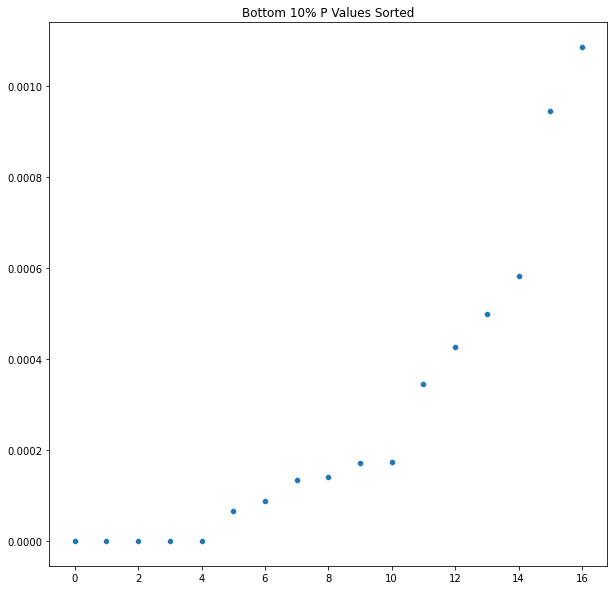

In [7]:
plt.rcParams['figure.figsize'] =  [10, 10]

sns.scatterplot(x=[i for i in range(len(bottom_ten))], y=bottom_ten)
plt.title("Bottom 10% P Values Sorted")
plt.show()

#### Part 2

Assume that different tests are independet; apply BH to select a set of winary pairs in which one winary is significantly better than the others while aiming for 0.05 false pairs. How many pairs were reported? is it more or less pairs than you discovered using Bonfferoni correction in HW4, Problem 4?

First, I'll reuse HW4 to see how many pairs are significant under Bonfferoni correction:

In [10]:
m = len(all_p_vals)
bonnferroni_sig_p_vals = [p for p in all_p_vals if p < ALPHA / 2 / m]
print(f"Under Bonfferoni correction, we got {len(bonnferroni_sig_p_vals)} significant pairs.")

Under Bonfferoni correction, we got 9 significant pairs.


In [18]:
ell = np.arange(1,m+1) / m * ALPHA
rejected = all_p_vals_sorted < ell
print(f"Under BH correction, we got {np.sum(rejected)} significant paris.")
print(f"Meaning, we got {np.sum(rejected) - len(bonnferroni_sig_p_vals)} more significant pairs under BH.")

Under BH correction, we got 40 significant paris.
Meaning, we got 31 more significant pairs under BH.


Let's plot it, just to get un understanding of the data:

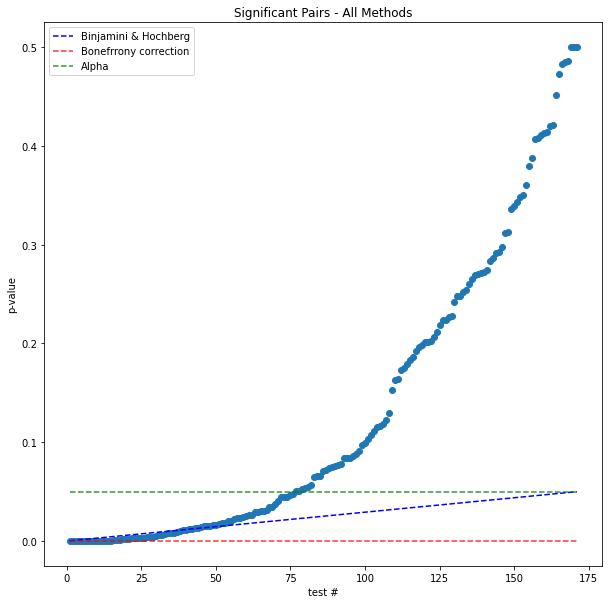

In [22]:
plt.scatter(np.arange(1, len(all_p_vals_sorted)+1), all_p_vals_sorted)

ell = np.arange(1, m+1) / m * ALPHA
plt.plot(np.arange(1,m+1), ell, '--b', label="Binjamini & Hochberg")

plt.plot([1, m], [ALPHA / m, ALPHA / m], '--r', alpha=.8, label="Bonefrrony correction")
plt.plot([1, m], [ALPHA, ALPHA], '--g',  alpha=.8, label="Alpha")

plt.ylabel('p-value')
plt.xlabel('test #')
plt.title("Significant Pairs - All Methods")
plt.legend()
plt.show()

#### Part 3
Repeat the last item without the independence assumption, i.e., use the harmonic sum correction.

In [29]:
ell_dep = np.arange(1,m+1) / m * ALPHA / (np.log(m))

rejected_dep = all_p_vals_sorted < ell_dep
print(f"Under BH correction without the indepedence assumption, we got {np.sum(rejected_dep)} significant paris.")
print(f"Meaning, we got {np.sum(rejected) - np.sum(rejected)} more significant pairs with the independence assumption.")

Under BH correction without the indepedence assumption, we got 15 significant paris.
Meaning, we got 0 more significant pairs with the independence assumption.


I'll add the new line to the plot showed before:

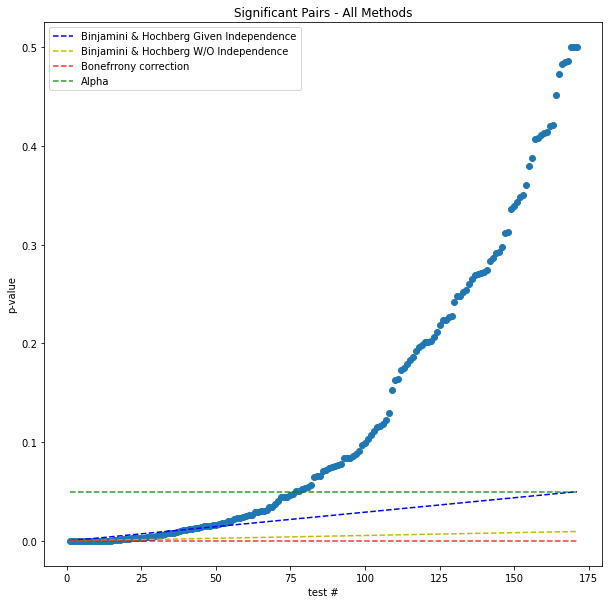

In [28]:
plt.scatter(np.arange(1, len(all_p_vals_sorted)+1), all_p_vals_sorted)

ell = np.arange(1, m+1) / m * ALPHA
plt.plot(np.arange(1,m+1), ell, '--b', label="Binjamini & Hochberg Given Independence")
plt.plot(np.arange(1,m+1), ell_dep, '--y', label="Binjamini & Hochberg W/O Independence")


plt.plot([1, m], [ALPHA / m, ALPHA / m], '--r', alpha=.8, label="Bonefrrony correction")
plt.plot([1, m], [ALPHA, ALPHA], '--g',  alpha=.8, label="Alpha")

plt.ylabel('p-value')
plt.xlabel('test #')
plt.title("Significant Pairs - All Methods")
plt.legend()
plt.show()

## Problem 2 (contrasts)
#### Continuation of Problem 1

Using a single t-test, test the assumption that the average of the Golan area wineries: ``Bazelet HaGolan``, ``Gamla``, ``Golan Heights Winary`` have the same quality as the average of Judean Hills area wineries: ``Katlav``, ``Psagot``, ``Shiloh Winery``, ``Titora``, ``Yatir`` (the goal here is to construct a "contrast", hence you should take an arithmetic average of group averages. You should only consider the size of each individual group when evaluating the varaince of the contrast).

Note: you can ignore the ``province`` filed in the data becasue it contains inaccurate information. You should also ignore the fact that in reality, ``Gamla`` is produced by ``Golan Heights Winary``. 



In [34]:
wine_df[wine_df.winery == 'Psagot']

,winery,points
3870,Psagot,89
25481,Psagot,87
31440,Psagot,89
73331,Psagot,87
76752,Psagot,88
86014,Psagot,87
133804,Psagot,87


In [75]:
golan = ['Bazelet HaGolan', 'Gamla', 'Golan Heights Winary']
judean = ['Katlav', 'Psagot', 'Shiloh Winery', 'Titora', 'Yatir']

golan_df = pd.concat([wine_df[wine_df.winery == winery] for winery in golan])
judean_df = pd.concat([wine_df[wine_df.winery == winery] for winery in judean])

golan_n = len(golan_df)
judean_n = len(judean_df)

golan_gb = golan_df.groupby('winery')
judean_gb = judean_df.groupby('winery')

y_hat_sum_golan = np.sum(golan_gb.mean()['points'])
y_hat_sum_judean = np.sum(judean_gb.mean()['points'])

t_num = y_hat_sum_golan / len(golan) - y_hat_sum_judean / len(judean)

s = np.sqrt(MSE_wit)

golan_len_sum = (1 / golan_gb.count()['points']).sum()
judean_len_sum = (1 / judean_gb.count()['points']).sum()

t_den = s * np.sqrt(1 / len(golan) ** 2 * (golan_len_sum) + 1 / len(judean) ** 2 * (judean_len_sum))

dof = len(wine_df) - len(golan) - len(judean)

p_val = st.t.sf(abs(t_num / t_den), dof)
can = "can" if p_val < ALPHA else "can't"

print(f"We {can} reject the hypothesis that the average Golan area winery has the same quality as the average of Judean Hills area wineries at prob = {ALPHA}")

We can reject the hypothesis that the average Golan area winery has the same quality as the average of Judean Hills area wineries at prob = 0.05


## Problem 3 (Exact size of Bonferroni's test)
Suppose that we run multiple tests with independent data and obtain P-values $p_1,\ldots,p_n$. We wish to test the null hypothesis:
$$
H_0\,:\,\text{All tests are null}
$$
at the level $\alpha$ (e.g., $\alpha=0.05$). In class, we introduced Bonferroni's procedure which is equivalent to: Reject $H_0$ if $\min p_i \leq \alpha/n$. 
1. Show that the  size of the test in Bonferroni's procedure is at most $\alpha$, regardless if the hypotheses are independent or not. 
2. Assuming that the hypotheses are independent, find the exact size of the test in Bonferroni's procedure. 
3. For $\alpha=0.05$, evalaute the difference between $\alpha$ and the exact test's size for $n=2,...,50$. Discuss what you see. 



If the $n$ hypotheses are independent, we know that the test size 

#### Part 3

In [93]:
ALPHA = 0.05 

bonferroni = [1 - ((1-ALPHA/i) ** i) for i in range(2,51)]
test_size = [1 - (1-ALPHA) ** i for i in range(2,51)]

I'll plot the data to see understand it better:

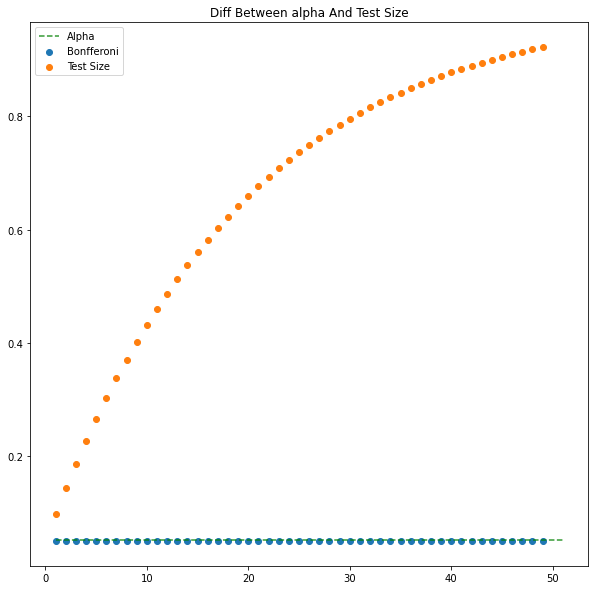

In [94]:
plt.scatter(np.arange(1, len(bonferroni)+1), bonferroni, label = "Bonfferoni")
plt.scatter(np.arange(1, len(test_size)+1), test_size, label = "Test Size")
plt.plot([1, 51], [ALPHA, ALPHA], '--g',  alpha=.8, label="Alpha")
plt.title("Diff Between alpha And Test Size")
plt.legend()
plt.show()

As visible, the more comparisons we perform, the higher the test size gets. However, the Bonfferoni adjustment stays relatively constant under $\alpha$.

## Problem 4 (Prediction in Simple Regression)
Consider the linear model:
$$
    y_i = \beta_0 + \beta_1 x_i + \epsilon_i,\qquad \epsilon_i \simiid \Ncal(0,\sigma^2)
$$
$$
    Z = \begin{pmatrix}
    1 & x_1 \\
    \vdots & \vdots \\
    1 & x_n
    \end{pmatrix},\quad \beta=\begin{pmatrix}
    \beta_0 \\
    \beta_1
    \end{pmatrix},\qquad \hat{\beta}=(Z^\top Z)^{-1} Z^\top y
$$
Suppose we get a new data point $x_{n+1}$ and want to predict $y_{n+1}$. We want an interval in which this prediction will likely to land. In class, we used that 
$$
\var[\hat{\beta}_0 + \hat{\beta}_1 x] = \frac{\sigma^2}{n} \left( \frac{1}{n} + \frac{(x-\bar{x})^2}{S_{XX }}\right)
$$
to obtain a confidence interval for $\beta_0 + \beta_1 x$, and a confidence band for all $x \in \reals$. In this question, you will use a similar reasoning to get a confidence interval (and bands) for $y_{n+1}$.
1. Find the varaince of $y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})$ in terms of $\sigma^2$ and $x_1,\ldots,x_n$ and $x_{n+1}$ (you can use $\bar{x}$ and $S_{XX}$ or any other well-defined function of $x_1,\ldots,x_n$). Explain intuitively why it makes sense that this variance is larger than the variance of  $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$. 
2. Find a $1-\alpha$ confidence interval for $y_{n+1}$. Is this interval wider or narrower than that of $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$? For what value of $x_{n+1}$ this interval is the narrowest?
3. Suppose that we take the average of two responses $y$'s at the same $x_{n+1}$, say 
$$
y_{n+1} =  \frac{y_{n+1}^{(1)} + y_{n+1}^{(2)}}{2}, 
$$
where
$$
y_{n+1}^{(1)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(1)}
$$
and 
$$
y_{n+1}^{(2)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(2)},
$$
where $\epsilon_{n+1}^{(1)}$ and $\epsilon_{n+1}^{(2)}$ are independent. Find a confidence interval for $y_{n+1}$. Is it wider or narrower than the interval in (2) ?

Note: The confidence interval you derived in 2 is somewhat risky to use becasue it makes the strong assumption that $\epsilon_{n+1}$ is normal. This is compared to, say, confidence intrvals for $\hat{\beta}_0$ and $\hat{\beta}_1$ which rely on averages over all observations $y_1,\ldots,y_n$ so we can use the Central Limit Theorem to argue for normality. Thigs gets better both in terms of varaince and normality assumption when you can take multiple measurements at the same $x_{n+1}$ and average those. 


#### Part 1
1. Find the varaince of $y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})$ in terms of $\sigma^2$ and $x_1,\ldots,x_n$ and $x_{n+1}$ (you can use $\bar{x}$ and $S_{XX}$ or any other well-defined function of $x_1,\ldots,x_n$). Explain intuitively why it makes sense that this variance is larger than the variance of  $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$. 


Basically, $y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})$ is the difference between the real value and the predicted value. We can calculate the variance of the term by:

$$
Var[y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})] = Var[y_{n+1}] - Var[\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}]
$$
$$
= \sigma ^ 2 - \sigma^2 ( \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{xx}})
$$
$$
= \sigma ^ 2 [1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{xx}}]
$$

It makes sense that the expression mentioned above will be larger than the variance of $\hat{\beta}_0 + \hat{\beta}_1 x$, as $\hat{\beta}_0 + \hat{\beta}_1 x$ as the $\beta$ coefficients were built based on $x_i, i \in [1,...,n]$ and were adjusted by it. However, the variance of the new instance, $y_{n+1}$, was not previously seen, hence it makes sense that the predicted error is larger than the one on previously seen data points.

#### Part 2
Find a  1−𝛼  confidence interval for  𝑦𝑛+1 . Is this interval wider or narrower than that of  𝛽̂ 0+𝛽̂ 1𝑥𝑛+1 ? For what value of  𝑥𝑛+1  this interval is the narrowest?

The confidence interval for $y_{n+1}$ as seen in class, is as follows:

$$
y_{n+1} \in [\hat{\beta}_0 + \hat{\beta}_1 X_{n+1} \pm t^{1-\frac{\alpha}{2}}_{n-2} s \sqrt{1 + \frac{1}{n} + \frac{x_{n+1} - \bar{x}}{S_{xx}}}]
$$

While the confidence interval for $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$ is:

$$
\hat{\beta}_0 + \hat{\beta}_1 x_{n+1} \in [\hat{\beta}_0 + \hat{\beta}_1 x_{n+1} \pm t^{1-\frac{\alpha}{2}}_{n-2} s \sqrt{\frac{1}{n} + \frac{x_{n+1} - \bar{x}}{S_{xx}}} ] 
$$

Since the latter does not have 1 in the root, it is narrower. It makes intuitive sense as the REAL value of $y_{n+1}$ should have a larger variance than the PREDICTED value, $\hat{y}_{n+1}$.
The invertal is at it's narrowest when $x_{n+1} = \bar{x}$, which again makes a lot of sense - most of the data is centralized around the mean value of $X$, $\bar{x}$, and around these values we are most confident in our prediction. 

#### Part 3
Suppose that we take the average of two responses $y$'s at the same $x_{n+1}$, say 
$$
y_{n+1} =  \frac{y_{n+1}^{(1)} + y_{n+1}^{(2)}}{2}, 
$$
where
$$
y_{n+1}^{(1)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(1)}
$$
and 
$$
y_{n+1}^{(2)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(2)},
$$
where $\epsilon_{n+1}^{(1)}$ and $\epsilon_{n+1}^{(2)}$ are independent. Find a confidence interval for $y_{n+1}$. Is it wider or narrower than the interval in (2) ?
